<a href="https://colab.research.google.com/github/buttersaltpepper/Financial-Data-Analytics/blob/main/HypothesisTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem: Is the Bank's Debt Recovery Strategy Worth the Human Resource Cost?**

*`bank_data.csv` from Datacamp*


**Brief**
* After debt is uncollectable, the bank will assess the expected recovery amount. 

* The greater the recovery amount, the more effort the bank puts into contacting the customer. But this has increased human resource costs

* The recovery amount is split into Strategy Levels at thresholds: 
  * 1000, 2000, 3000, 5000,
  * and each level incurs an additional $50 human resource expense per customer.


**Objective**

To find out if the increased recovery amount at higher levels are worth the extra costs per customer

**Method**
* Analyse data at the 1000 threshold
* If any discontinuity occurs at these areas, it may mean the increased recovery amount is not caused by better recovery strategy and is caused by other factors such as age or sex. 
* Build a regression model to quantify the benefit of recovery strategies.
* If coefficient is greater than the $50 cost, it is worth it. 
 



In [ ]:
import pandas as pd
import numpy as np

from scipy import stats # statistical inferece
from scipy.stats import kurtosis, skew # normality tests

from sklearn.linear_model import LinearRegression # heteroscedascity tests
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm


import seaborn as sns
import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (10,5)

In [ ]:
df = pd.read_csv('bank_data.csv') # dataset from Datacamp
df.dtypes, df.shape

(id                            int64
 expected_recovery_amount      int64
 actual_recovery_amount      float64
 recovery_strategy            object
 age                           int64
 sex                          object
 dtype: object, (1882, 6))

In [ ]:
df.isna().sum()

id                          0
expected_recovery_amount    0
actual_recovery_amount      0
recovery_strategy           0
age                         0
sex                         0
dtype: int64

In [ ]:
# Very clean csv. which is not good for learning :(
df.nunique()

id                          1882
expected_recovery_amount    1529
actual_recovery_amount      1882
recovery_strategy              5
age                           67
sex                            2
dtype: int64

In [ ]:
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


In [ ]:
# start with Numerical Variables
X = df.select_dtypes(exclude='O').drop('id',axis=1)
y = df['actual_recovery_amount']

In [ ]:
# Start with Pearsons correlation, Normality test
num_stats_df = pd.DataFrame(columns=['Stat', '+/-', 'Effect size', 'p-value', 'Kurtosis', 'Skewness'])

for col in X:
  # Pearsons correlation
  r, p = stats.pearsonr(y, df[col])

  # Normality tests
  k = kurtosis(X[col])
  s = skew(X[col])

  num_stats_df.loc[col] = ['r', np.sign(r), round(r,3), round(p,6), round(k,3), round(s,3)]

num_stats_df.sort_values(by='Effect size', ascending=False)

,Stat,+/-,Effect size,p-value,Kurtosis,Skewness
actual_recovery_amount,r,1.0,1.000,0.0,6.720,2.288
expected_recovery_amount,r,1.0,0.904,0.0,1.583,1.434
age,r,1.0,0.716,0.0,-0.127,0.809


**First, focus around the $1000 area to see if there is a discontinuity**

* If there is discontinuity, this is bad because it means the expected payoff is affected by other factors other than the recovery strategy.
* We want the recovery amount to be consistent to be able to analyse the coefficient of bank's strategy effort

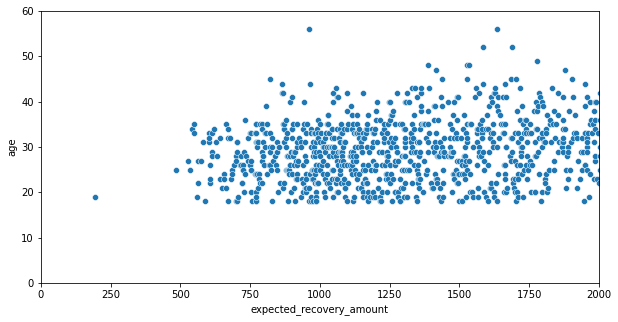

In [ ]:
sns.scatterplot(y=df.age, x=df.expected_recovery_amount);
plt.xlim(0, 2000)
plt.ylim(0, 60);

In [ ]:
df_900_1100 = df.loc[(df['expected_recovery_amount']<1100) & 
                      (df['expected_recovery_amount']>=900)]

df_900_1100.groupby('recovery_strategy')['age'].describe()
# There seems to be no difference, no discontinuity.
# Need to test this with t-test

,count,mean,std,min,25%,50%,75%,max
recovery_strategy,,,,,,,,
Level 0 Recovery,89.0,27.224719,6.399135,18.0,23.0,26.0,31.0,56.0
Level 1 Recovery,94.0,28.755319,5.859807,18.0,24.0,29.0,33.0,43.0


In [ ]:
df_900_1100_test = df_900_1100.groupby('recovery_strategy')['age'].apply(list)

stats.ttest_ind(*df_900_1100_test)

Ttest_indResult(statistic=-1.6888055955231507, pvalue=0.09297868115283911)

**STATISTICALLY NO DIFFERENCE**

This is important because we want to be able to conclude that differences in the actual recovery amount are due to the higher Recovery Strategy and not due to some other difference like age or sex.

In [ ]:
# Do the same for sex vs expected recovery amount
# but this time use Chi2 since sex is categorical data

# Chi squared independence test
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount'] < 1100) & 
                   (df['expected_recovery_amount'] > 900)]['recovery_strategy'], df['sex'])

print(crosstab)

x2, p, dof, ex = stats.chi2_contingency(observed=crosstab)

print('chi2 stat: ',x2, 'p-value: ',p)

# also not statistically different. So no discontinuity

sex                Female  Male
recovery_strategy              
Level 0 Recovery       31    55
Level 1 Recovery       39    55
chi2 stat:  0.35423507714452734 p-value:  0.5517254907831952


In [ ]:
sns.scatterpoint()

**Scatter plot of Expected Recovery Amount (X) versus Actual Recovery Amount (Y) for Expected Recovery Amounts between 900 to 1100**

A key question is whether or not we see a discontinuity (jump) around the $1000 threshold.

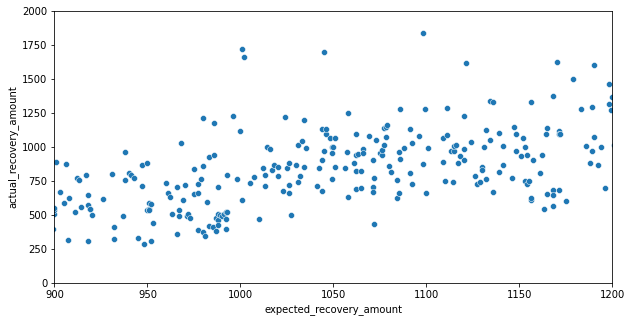

In [ ]:
sns.scatterplot(x = df.expected_recovery_amount, y = df.actual_recovery_amount)
plt.xlim(900,1200)
plt.ylim(0,2000);

In [ ]:
# Numerical vs Numerical so can use t-test, or Kruskal test
# lets use both

In [ ]:
df_900_1100 = df.loc[(df.expected_recovery_amount < 1100) & 
                    (df.expected_recovery_amount >= 900)]

df_900_1100_test = df_900_1100.groupby('recovery_strategy')['actual_recovery_amount'].apply(list)



print('Single t-test: ', stats.ttest_ind(*df_900_1100_test))
print('Kruskal test: ', stats.kruskal(*df_900_1100_test))

Single t-test:  Ttest_indResult(statistic=-8.752120480758053, pvalue=1.4447438647832293e-15)
Kruskal test:  KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)


**Those statistical tests were done so we know that non of those features affect the recovery amount at each threshold. Thats why we focused on the 900-1100 area so we can analyze if theres any change at the threshold level**

**Regression Modelling**

In [ ]:
import statsmodels.api as sm


y = df_900_1100[['actual_recovery_amount']]
X = df_900_1100[['expected_recovery_amount']].assign(const=1)

model = sm.OLS(y, X).fit()
prediction = model.predict(X)

print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Sat, 24 Sep 2022   Prob (F-statistic):           1.56e-13
Time:                            12:27:26   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

**Interpretation:**

* the coef is statistically significant.
* The coef for this model actually measures the size of discontinuity for customers jsut around the 1000 threshold
* Since coef is small, it indicates no discontinuity when Level 0 changes to Level 1


**Adding threshold**

* Add indicator variable (0 or 1) that represents whether the expected recovery amount was greater than 1000
* If the higher recovery strategy helped recovery more money, then the regression coefficient of the true threshold will be greater than zero. If the higher recovery strategy did not help recovery more money, then the regression coefficient will not be statistically significant.

In [ ]:
df_900_1100['indicator_1000'] = np.where(df_900_1100.expected_recovery_amount < 1000, 0 , 1)

# Define X and y
X = df_900_1100[['expected_recovery_amount', 'indicator_1000']].assign(const=1)
y = df_900_1100.actual_recovery_amount 

# Build linear regression model
model = sm.OLS(y, X).fit()
model.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Sat, 24 Sep 2022   Prob (F-statistic):           1.83e-15
Time:                            12:40:32   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
expected_recovery_amount     0.6430      0.655      0.981      0.328      -0.650       1.936
indicator_1000             277.6344     74.043      3.750      0.000     131.530     423.739
const                        3.3440    626.274      0.005      0.996   -1232.440    1239.128
==============================================================================
Omnibus:                       65.977   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.537
Skew:                           1.510   Prob(JB):                     3.12e-41
Kurtosis:                       6.917   Cond. No.                     3.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Results:**
The regression coefficient for the true threshold was statistically significant with an estimated impact of around 278. This is much larger than the 50 per customer needed to run this higher recovery strategy.

This means different recovery strategies run by the bank works! and they are recoverying more!

**BUT, this was only modelled at the 900-1100 threshold**





In [ ]:
# Decrease window to 950 - 1050
df_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & 
                      (df['expected_recovery_amount']>=950)]


df_950_1050['indicator_1000'] = np.where(df_950_1050.expected_recovery_amount < 1000, 0 , 1)

X = df_950_1050[['expected_recovery_amount', 'indicator_1000']].assign(const=1)
y = df_950_1050['actual_recovery_amount']

model = sm.OLS(y, X).fit()

model.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Sat, 24 Sep 2022   Prob (F-statistic):           1.12e-07
Time:                            12:46:45   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
expected_recovery_amount     0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000             286.5337    111.352      2.573      0.012      65.502     507.566
const                     -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## **Conclusion:**

The banks different strategies for different debt recovery actually works!

And it is well worth the $50 cost per customer

# **One Sample Proportion Test: z-test**

Single variable test
* H0: $\bar{x} = u$
* Ha: $\bar{x} \neq u$

$z = \frac{sample stat - population parameter}{standard error}$

A z-test can only be used if the population standard deviation is known and the sample size is 30 data points or larger.

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm

In [ ]:
late_shipments = pd.read_feather('https://assets.datacamp.com/production/repositories/5982/datasets/887ec4bc2bcfd4195e7d3ad113168555f36d3afa/late_shipments.feather')

0.061

In [ ]:
# First, lets have a look at sample mean
sample_mean = (late_shipments['late'] == 'Yes').mean()
print('sample_mean: ', sample_mean)


# Check test if it is statistically significant
std_error = 0.00749 # The std error
late_prop_hyp = 0.06 # Our Null Hypothesis

z_score = (sample_mean - late_prop_hyp) / std_error

p_value = norm.cdf(1 - z_score)


print('z_score: ', z_score, 'p-value: ', p_value)

if p_value > 0.05:
  print('Failed to reject Null Hypothesis. The sample mean and population mean has no significant differnce')

sample_mean:  0.061
z_score:  0.13351134846461962 p-value:  0.806888876457349
Failed to reject Null Hypothesis. The sample mean and population mean has no significant differnce


# **Two-Sample: ANOVA and t-test**
*t-distribution is a fat tailed normal distribution*

What if we want to compare sample vs sample? we cannot use z-test

* H0: $u_1 = u_2$  
* Ha: $u_1 \neq u_2$

Does Response Variable's mean differ between sample groups?


In [ ]:
from scipy import stats # for single pair 

In [ ]:
late_shipments.groupby('late_delivery')['pack_price'].mean()

late_delivery
0.0    35.951076
1.0    46.110984
Name: pack_price, dtype: float64

## **Single Pair**

In [ ]:
late_delivery_test = late_shipments.groupby('late_delivery')['pack_price'].apply(list)

# Single Pair t-test
t, p = stats.ttest_ind(late_delivery_test[0], late_delivery_test[1])
print('t-stat: ', t, 'p-value: ', p)

t-stat:  -1.6163251640221612 p-value:  0.10634006467955008


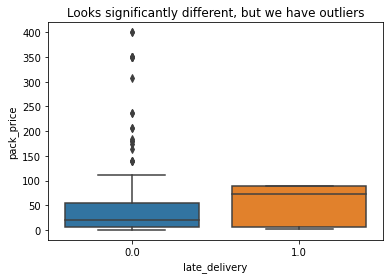

In [ ]:
sns.boxplot(data=late_shipments,
            x='late_delivery',
            y='pack_price');

plt.title('Looks significantly different, but we have outliers');

## **Pairwise: Tuskey's HSD**

In [ ]:
from statsmodels.stats.multicomp import MultiComparison # for multiple Pairwise tests
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
late_shipments.groupby('shipment_mode')['pack_price'].mean()

shipment_mode
Air            39.712395
Air Charter     4.226667
Ocean           6.432273
Name: pack_price, dtype: float64

In [ ]:
mc = MultiComparison(late_shipments.pack_price, late_shipments.shipment_mode)
print(mc.tukeyhsd())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj  lower    upper   reject
---------------------------------------------------------------
        Air Air Charter -35.4857 0.152 -80.3336   9.3621  False
        Air       Ocean -33.2801 0.001 -45.5058 -21.0545   True
Air Charter       Ocean   2.2056   0.9 -43.9932  48.4044  False
---------------------------------------------------------------


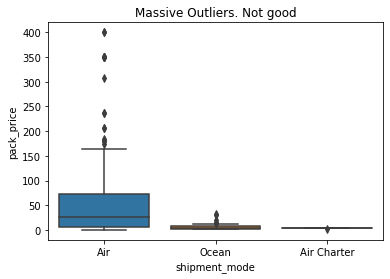

In [ ]:
sns.boxplot(data=late_shipments, 
            y='pack_price',
            x='shipment_mode');

plt.title('Massive Outliers. Not good');

# **Chi-Square Test of Independence**
If proportions across categories are same = Independent

**Statistical independence** 

proportion of successes in the response variable is the same across all categories of the explnatory variable

In [ ]:
props = late_shipments.groupby('vendor_inco_term')['freight_cost_groups'].value_counts(normalize=True)
wide_props = props.unstack().dropna()
wide_props

freight_cost_groups,expensive,reasonable
vendor_inco_term,,
CIP,0.320000,0.680000
DDP,0.550000,0.450000
EXW,0.583448,0.416552
FCA,0.336364,0.663636


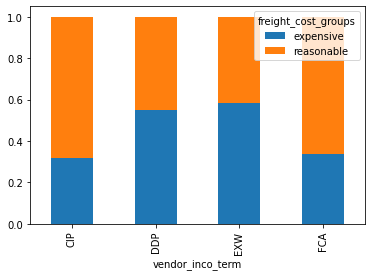

In [ ]:
wide_props.plot(kind='bar', stacked=True);

In [ ]:
print('t: ', stats.chi2_contingency(observed=wide_props)[0])
print('p-value: ', 1 - stats.chi2_contingency(observed=wide_props)[1]) # because X2 is a right tail test

t:  0.2329558052596161
p-value:  0.02789846987131228


# **Chi-Square Goodness of Fit Test**
Compares single cateogrical variable to hypothesised distribution

H0: Sample distribution $=$ Hypothesied Distribution

Ha: Sample distribution $\neq$ Hypothesied Distribution

In [ ]:
hypothesised = pd.DataFrame({'vendor_inco_term': ['CIP','DDP','EXW','FCA'], 'prop': [0.05,0.10,0.75,0.10]})
hypothesised['n'] = hypothesised.prop * len(late_shipments)
hypothesised

,vendor_inco_term,prop,n
0,CIP,0.05,50.0
1,DDP,0.10,100.0
2,EXW,0.75,750.0
3,FCA,0.10,100.0


In [ ]:
observed = pd.DataFrame({'vendor_inco_term': ['CIP','DDP','EXW','FCA'], 'n': [57,100,732,111]})
observed

,vendor_inco_term,n
0,CIP,57
1,DDP,100
2,EXW,732
3,FCA,111


In [ ]:
stats.chisquare(f_obs = observed['n'],
                f_exp = hypothesised['n'])

Power_divergenceResult(statistic=2.622, pvalue=0.4536457101903294)

Text(0.5, 1.0, 'The sample follows the hypothesised distribution')

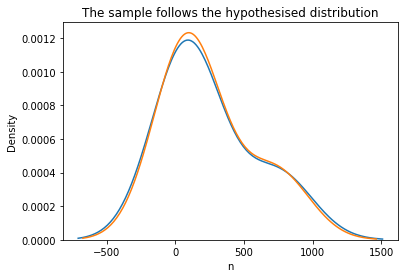

In [ ]:
sns.kdeplot(hypothesised.n);
sns.kdeplot(observed.n);
plt.title('The sample follows the hypothesised distribution')

# **Assumptions in Parametric Hypothesis Tests**

1. Random samples
  * Each sample is randomly sourced from its population 
  * NOT randomly select means it wont be a representation of pop
2. Independence of observations
  * Each observation is independent
  * If observations are dependent on each other, there is increased chance of False Negative and False Positive errors
3. Large sample size so CLT applies
* Large enough sample size allows for normal distribution and CLT to hold
* Smaller samples = greater uncertainty = non-normal = CLT doesn't apply
* $n >= 30$ for t-tests
* $n >= 10$ for proportion tests
* $n >= 5$ for Chi-Square

* Simple Histogram check


# **Wilcoxon signed-rank test**

H0: $\bar{x} - \bar{x} = 0$

Ha: $\bar{x} - \bar{x} \neq 0$

**It is a non-parametric version of the paired T-test.**

Tests the null hypothesis that two related paired samples come from the same distribution. 

In particular, it tests whether the distribution of the differences x - y is symmetric about zero. 



In [ ]:
sample_dem_data = pd.read_feather('https://assets.datacamp.com/production/repositories/5982/datasets/4ab6431d773d1fe659ac120b4b49a1b525a76712/dem_votes_potus_12_16.feather')

In [ ]:
y = sample_dem_data.dem_percent_12
X = sample_dem_data.dem_percent_16

w, p =stats.wilcoxon(x=X, y=y, alternative='two-sided')

print('w-stat: ', w, 'p-value: ', p)

w-stat:  2401.0 p-value:  1.775257379107445e-77


# **Wilcoxon-Mann-Whitney**
**The Non-parametric Unpaired T-Test**



In [ ]:
stack_overflow = pd.read_feather('https://assets.datacamp.com/production/repositories/5982/datasets/c59033b93930652f402e30db77c3b8ef713dd701/stack_overflow.feather')

In [ ]:
age_vs_comp = stack_overflow[['converted_comp', 'age_first_code_cut']]
age_vs_comp_long = age_vs_comp.groupby('age_first_code_cut')['converted_comp'].apply(list)

In [ ]:
stats.mannwhitneyu(x=age_vs_comp_long[1], 
                   y=age_vs_comp_long[0],
                   alternative='greater')

MannwhitneyuResult(statistic=744365.5, pvalue=1.9027232924005235e-19)

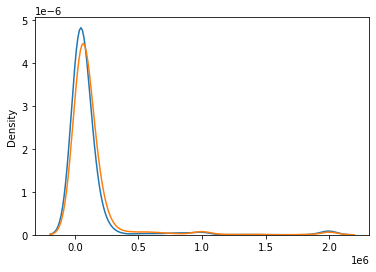

In [ ]:
sns.kdeplot(age_vs_comp_long[0])
sns.kdeplot(age_vs_comp_long[1]);

# **Kruskal-Wallis**
**The Non-parametric ANOVA**

In [ ]:
job_sat_vs_comp = stack_overflow[['converted_comp', 'job_sat']]
job_sat_vs_comp_long = job_sat_vs_comp.groupby('job_sat')['converted_comp'].apply(np.hstack)

In [ ]:
stats.kruskal(*job_sat_vs_comp_long)

KruskalResult(statistic=72.81493915023472, pvalue=5.772915423012869e-15)

# **Linear Regression Basics**

$response = intercept + constant * explanatory$

$y = mx + b$

Fits straight line thorugh that that minimises sum of squared residuals. OLS

**Assumption**
 - Linear relationship
 - Homosced

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import linear_model

In [ ]:
mtcars = pd.read_csv('mtcars.csv')

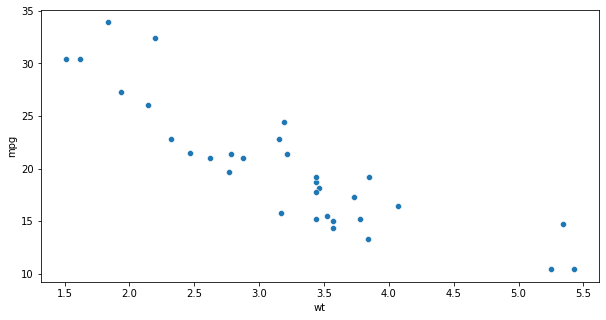

In [ ]:
sns.scatterplot(x=mtcars.wt, 
                y=mtcars.mpg, 
                );

In [ ]:
# initialise/create model
model = linear_model.LinearRegression()

# train model on data
model.fit(X = pd.DataFrame(mtcars['wt']),
          y=mtcars['mpg'])

print('b: ', model.intercept_)
print('m: ', model.coef_)

# regression score r^2
print('r2: ', model.score(X = mtcars[['wt']],
            y=mtcars[['mpg']]))

b:  37.28512616734204
m:  [-5.34447157]
r2:  0.7528327936582646


In [ ]:
# The r2 is based on residuals, 
# which can be extracted by making a prediction then substractying the actual value

# Predict
train_predict = model.predict(X = pd.DataFrame(mtcars['wt']))

# Predict - Actual
residuals = mtcars['mpg'] - train_predict
residuals.describe()

count    3.200000e+01
mean    -8.215650e-15
std      2.996352e+00
min     -4.543151e+00
25%     -2.364709e+00
50%     -1.251956e-01
75%      1.409561e+00
max      6.872711e+00
Name: mpg, dtype: float64

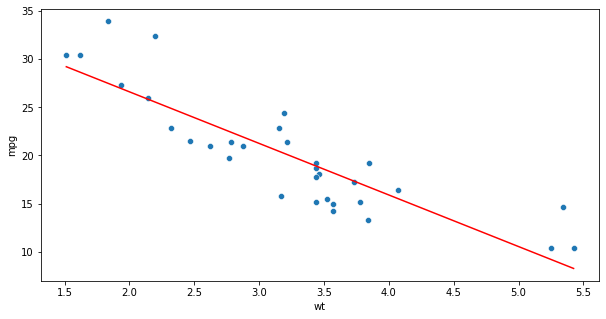

In [ ]:
sns.scatterplot(x=mtcars.wt, 
                y=mtcars.mpg, 
                )

sns.lineplot(x=mtcars.wt, 
             y=train_predict,
             color='r');

**A SINGLE OUTLIER CAN AFFECT THE REGRESSION MODEL**

* Linear regression models minimises the sum of squared differences
* So any points very far away magnifies the difference even more.
* So any outlier should be removed

**We want residuals to be roughly normally distributed**
* Can visualise with a Q-Q Plot (Quantile-Quantile)

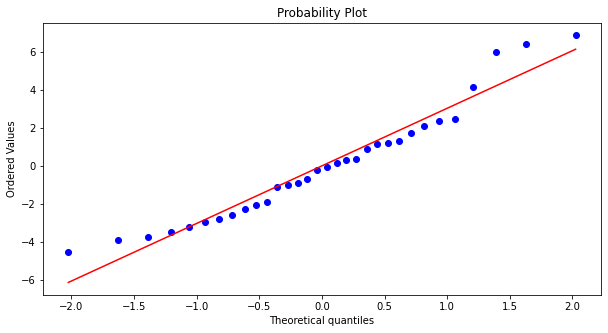

In [ ]:
stats.probplot(residuals, dist='norm', plot=plt);

# The divergence around the top-right corner indicate residuals are not completely normal

**Model Evaluation: Root mean squared error (RMSE)**

* the R^s can be used to compare Linear Regression Models but can't be compared to other models

* this is a universal measurement to compare different types of models


In [ ]:
from sklearn.metrics import mean_squared_error 

RMSE = mean_squared_error(train_predict, mtcars.mpg)**0.5
RMSE

2.949162685955028

# **Polynomial Regression**
* When there is non linear relationship
* This transforms some explanatory variable by squarring them, cubic, or other polynomial transformation

In [ ]:
# initialise model object
poly_model = linear_model.LinearRegression()

# Add extra varaible with a squared adjustment 
predictors = pd.DataFrame([mtcars['wt'],       # weight
                           mtcars['wt']**2]).T # weight squared

# Train model
poly_model.fit(X = predictors,
               y = mtcars.mpg)

print('Model Intercept')
print(poly_model.intercept_)


print('Model Coefficients')
print(poly_model.coef_)

print('R-squared')
print(poly_model.score(X = predictors,
                       y = mtcars['mpg']))

Model Intercept
49.93081094945181
Model Coefficients
[-13.38033708   1.17108689]
R-squared
0.8190613581384095


**The r2 has increased to 0.819**
* so this implies this new model expalins significantly more than the indpenedent model
* But we shouldn't use the r2 if we add more variables

we can use **Adjusted R-squared** if we add lots of variables

In [ ]:
# plot curve
poly_line_range = np.arange(1.5, 5.5, 0.1)

# get first and second ord predictors from range
poly_predictors = pd.DataFrame([poly_line_range,
                                poly_line_range**2]).T

y_values = poly_model.predict(X = poly_predictors)

mtcars.plot(kind='scatter',
            x='wt',
            y='mpg',
            xlim=(0,7))

plt.plot(poly_line_range, y_values);

NameError: ignored

**Over-fitting**

- fitting our model too closely to training data
- this leads to bias